## 1. ВВОДНАЯ ЧАСТЬ

**ТИТУЛЬНАЯ ЧАСТЬ**

Название: Повышение разрешения изображений с помощью автокодировщиков с глубокими сверточными сетями
Автор: Носачёв Сергей
Дата: 0.4 0.9 2025

**ВВЕДЕНИЕ**

В данной работе рассматривается задача увеличения разрешения изображений (Super-Resolution).
Проблема важна для медицины, спутниковой съемки и компьютерного зрения.
Цель исследования — разработка и апробация моделей на основе сверточных автокодировщиков.

## 2. УСТАНОВКА И ИМПОРТ БИБЛИОТЕК

In [ ]:
!git clone https://github.com/snosachyev/increasing_image_resolution.git src

Cloning into 'src'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 31 (delta 12), reused 27 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 6.43 KiB | 6.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
import sys
sys.path.append('src')
import importlib

# в режиме редактирования сбрасуем кэшь иначе не видно изменений
for module in [
    "models",
    "utils",
    "dataset"

]:
    imported_module = importlib.import_module(module)
    importlib.reload(imported_module)

In [ ]:
import os
import cv2

import matplotlib.pyplot as plt

# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

from keras import utils as keras_utils

from dataset import datasetGenerator
from models import create_cnn_autoencoder_model, create_residual_block_model
from utils import update_history, show_loss, psnr, mse, create_input_img_path, load_data, noise_image, load_history


%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
epochs = 5 #@param {type:"slider", min:1, max:20, step:1}
print(f"Выбрано эпох для обучения: {epochs}")

batch_size = 16 #@param {type:"number"}
learning_rate = 0.001 #@param {type:"number"}
use_drive = True #@param {type:"boolean"}
last_epoch = 5 #@param {type:"number"}

print(f"Выбрано последняя эпоха для загрузки весов: {last_epoch}")

root_dataset = ""
if use_drive:
  root_dataset = "drive/MyDrive/"

folder_path_train = os.path.join(root_dataset, "dataset/train/")
folder_path_test = os.path.join(root_dataset, "dataset/test/")
anotation_file = os.path.join(root_dataset, "dataset/train/annotation.txt")

size = 256
reduce_size = 128
img_size=(size, size)
reduce_img_size=(reduce_size, reduce_size)

Выбрано эпох для обучения: 2
Выбрано последняя эпоха для загрузки весов: 5


## 3. ТЕОРЕТИЧЕСКАЯ ЧАСТЬ

**Теоретическая база**

Существуют разные подходы к Super-Resolution:
- Интерполяционные методы (bicubic и др.)
- Глубокие сверточные сети (SRCNN, ESPCN)
- Генеративные модели (GAN, SRGAN)

В данной работе мы сосредоточимся на разных архитектурах сверточных автокодировщиков:
- Базовый CNN-автокодировщик
- Residual Autoencoder (с остаточными связями)

Кодировщик будет состоять из стека слоев Conv2D, MaxPooling2D. MaxPooling2D для сжатия пространства. Декодер из блоков Conv2D, UpSampling2D. Cлой UpSampling2D - для "растяжения" данных.
Выбор в пользу слоя UpSampling2D с повышеной дикретизацией обоснован, тем что она использует математическое определение (интерполяцию), а так как у нас данные не однородные то их сложно обучить, то это то что нужно.

**Методология**
- Датасет: LabelMe-12-50k (изображения 256x256)
- Подход: сравнение базового CNN-автокодировщика и Residual Autoencoder
- Инструменты: Python, TensorFlow/Keras, matplotlib, pandas


**Список литературы**

[1] Dong et al., "Image Super-Resolution Using Deep Convolutional Networks" (2015)

[2] Ledig et al., "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" (2017)

[3] He et al., "Deep Residual Learning for Image Recognition" (2016)

[4] Chollet, F. Deep Learning with Python (2017)

[5] https://www.tensorflow.org/tutorials/images/segmentation?hl=ru

[6] https://www.tensorflow.org/tutorials/generative/cvae?hl=ru


## 4. ПОДГОТОВКА ДАННЫХ

In [ ]:
# загружаем датасет
!wget https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz

# распакуем в папку dataset
!mkdir dataset
!tar -xvzf LabelMe-12-50k.tar.gz -C dataset

# копируем в гугл диск, что бы не скачивать постоянно
!cp -r dataset drive/MyDrive/

Выходные данные были обрезаны до нескольких последних строк (5000).
train/0004/004126.jpg
train/0004/004125.jpg
train/0004/004124.jpg
train/0004/004123.jpg
train/0004/004122.jpg
train/0004/004121.jpg
train/0004/004120.jpg
train/0004/004119.jpg
train/0004/004118.jpg
train/0004/004117.jpg
train/0004/004116.jpg
train/0004/004115.jpg
train/0004/004114.jpg
train/0004/004113.jpg
train/0004/004112.jpg
train/0004/004111.jpg
train/0004/004110.jpg
train/0004/004109.jpg
train/0004/004108.jpg
train/0004/004107.jpg
train/0004/004106.jpg
train/0004/004105.jpg
train/0004/004104.jpg
train/0004/004103.jpg
train/0004/004102.jpg
train/0004/004101.jpg
train/0004/004100.jpg
train/0004/004099.jpg
train/0004/004098.jpg
train/0004/004097.jpg
train/0004/004096.jpg
train/0004/004095.jpg
train/0004/004094.jpg
train/0004/004093.jpg
train/0004/004092.jpg
train/0004/004091.jpg
train/0004/004090.jpg
train/0004/004089.jpg
train/0004/004088.jpg
train/0004/004087.jpg
train/0004/004086.jpg
train/0004/004085.jpg
train/00

*Соберём все пути изображений в список*

In [ ]:
train_input_img_path = create_input_img_path(folder_path_train)
test_input_img_path = create_input_img_path(folder_path_test)

In [ ]:
train_gen = datasetGenerator(batch_size, train_input_img_path, img_size=img_size)
test_gen = datasetGenerator(batch_size, test_input_img_path, img_size=img_size)

**Подготовим изображения для тестирования**

In [ ]:
# Загружаем датасет
x_test = load_data(test_input_img_path[:5], target_size=img_size)

# Нормализация
x_test = x_test / 255.

# Понижаем разрешение (имитация низкого качества)
low_res_test = tf.image.resize(x_test, (16, 16)).numpy()

# Восстанавливаем до исходного размера для подачи в сеть
low_res_test = tf.image.resize(low_res_test, img_size).numpy()

**Посмотрим на изображения**

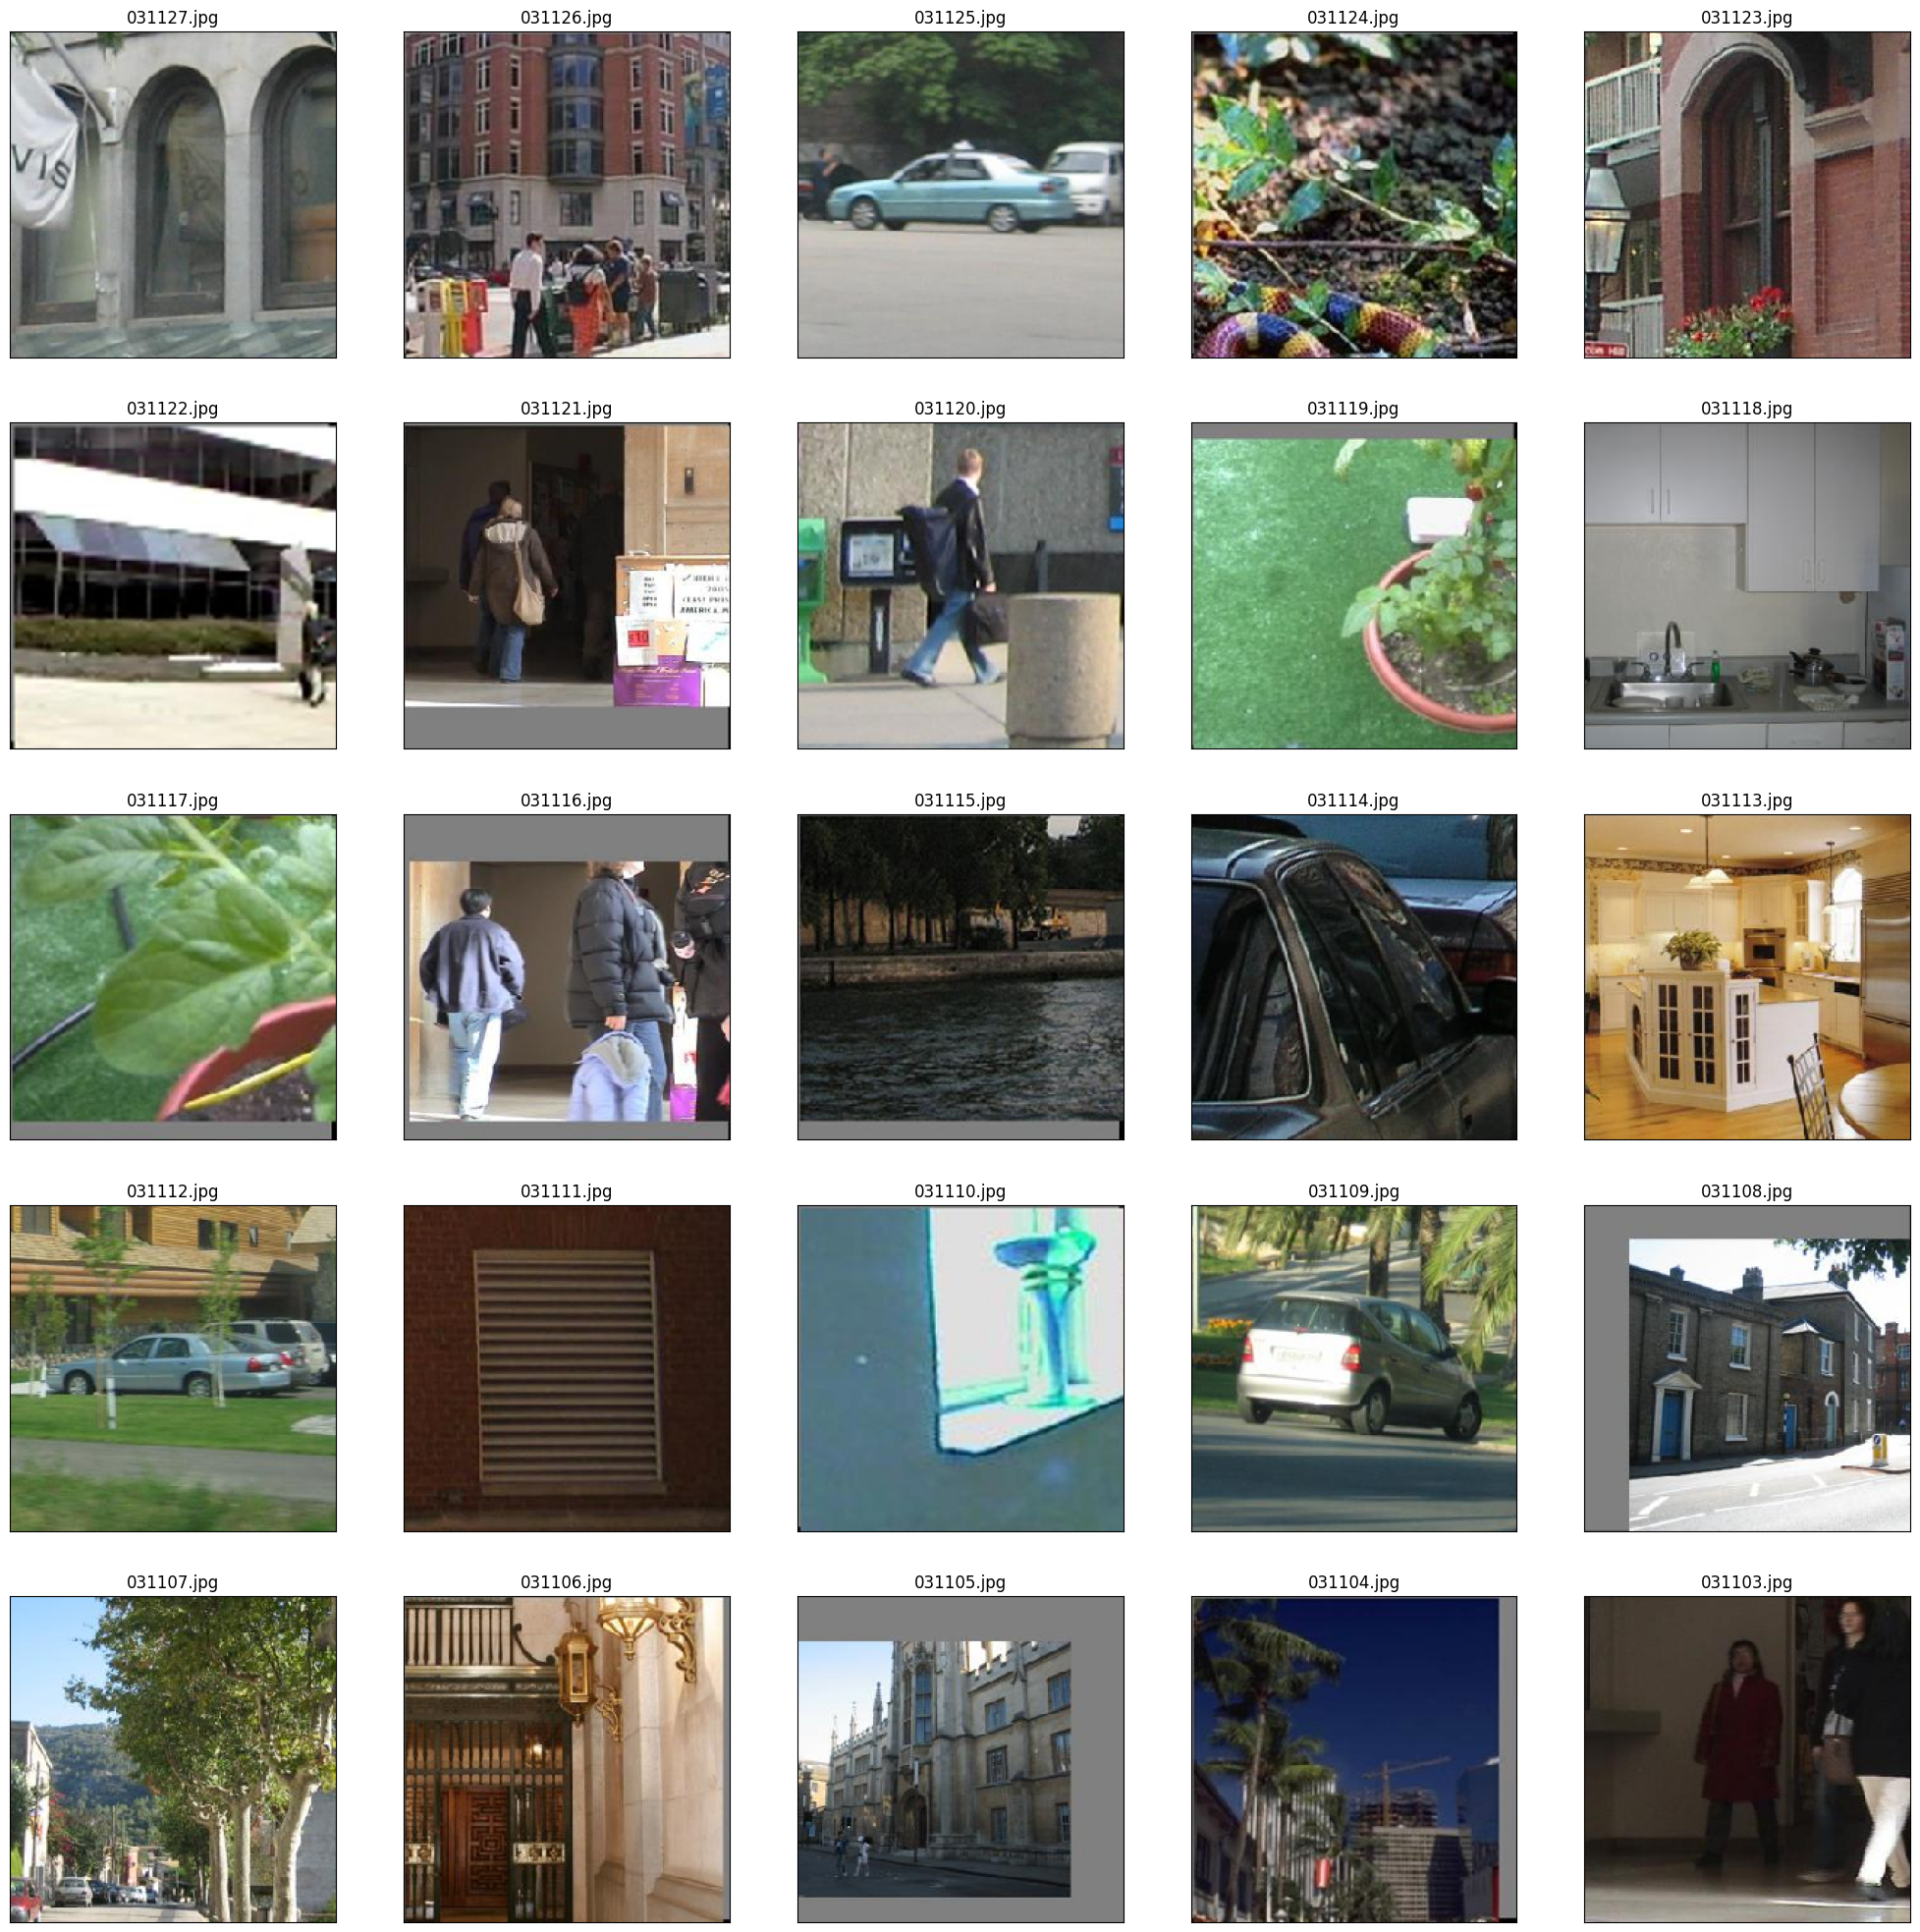

In [ ]:
plt.figure(figsize=(25, 25))

for dir_name in os.listdir(folder_path_train):
    image_dir = os.path.join(folder_path_train, dir_name)
    if os.path.isdir(image_dir):
        for i, filename in enumerate(os.listdir(image_dir)[:25]):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_path = os.path.join(image_dir, filename)
                plt.subplot(5, 5, i+1)
                plt.title(filename)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                # Load the image (replace 'path/to/your/image.jpg' with your actual image path)
                img = keras_utils.load_img(image_path, target_size=(224, 224)) # Optional: resize the image

                # Преобразуем картинку в формат RGB перед выводом
                plt.imshow(img)
plt.show()

## 5. РЕАЛИЗАЦИЯ МОДЕЛИ

In [ ]:
cnn_checkpoint_dir = os.path.join(root_dataset, f'checkpoints/cnn_autoencoder_{size}')
residual_checkpoint_dir = os.path.join(root_dataset, f'checkpoints/residual_autoencoder_{size}')

cnn_autoencoder_checkpoint = os.path.join(cnn_checkpoint_dir, 'train_{epoch}.weights.h5')
residual_autoencoder_checkpoint = os.path.join(residual_checkpoint_dir, 'train_{epoch}.weights.h5')
cnn_autoencoder_callbacks = [
            ReduceLROnPlateau(verbose=1),
            EarlyStopping(patience=3, verbose=1),
            ModelCheckpoint(cnn_autoencoder_checkpoint,
                            verbose=1, save_weights_only=True),
            TensorBoard(log_dir='logs')
        ]

residual_autoencoder_callbacks = [
            ReduceLROnPlateau(verbose=1),
            EarlyStopping(patience=3, verbose=1),
            ModelCheckpoint(residual_autoencoder_checkpoint,
                            verbose=1, save_weights_only=True),
            TensorBoard(log_dir='logs')
        ]

cnn_autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
residual_autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 192)    │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 192)    │       442,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069,123 (7.89 MB)

 Trainable params: 2,069,123 (7.89 MB)

 Non-trainable params: 0 (0.00 B)

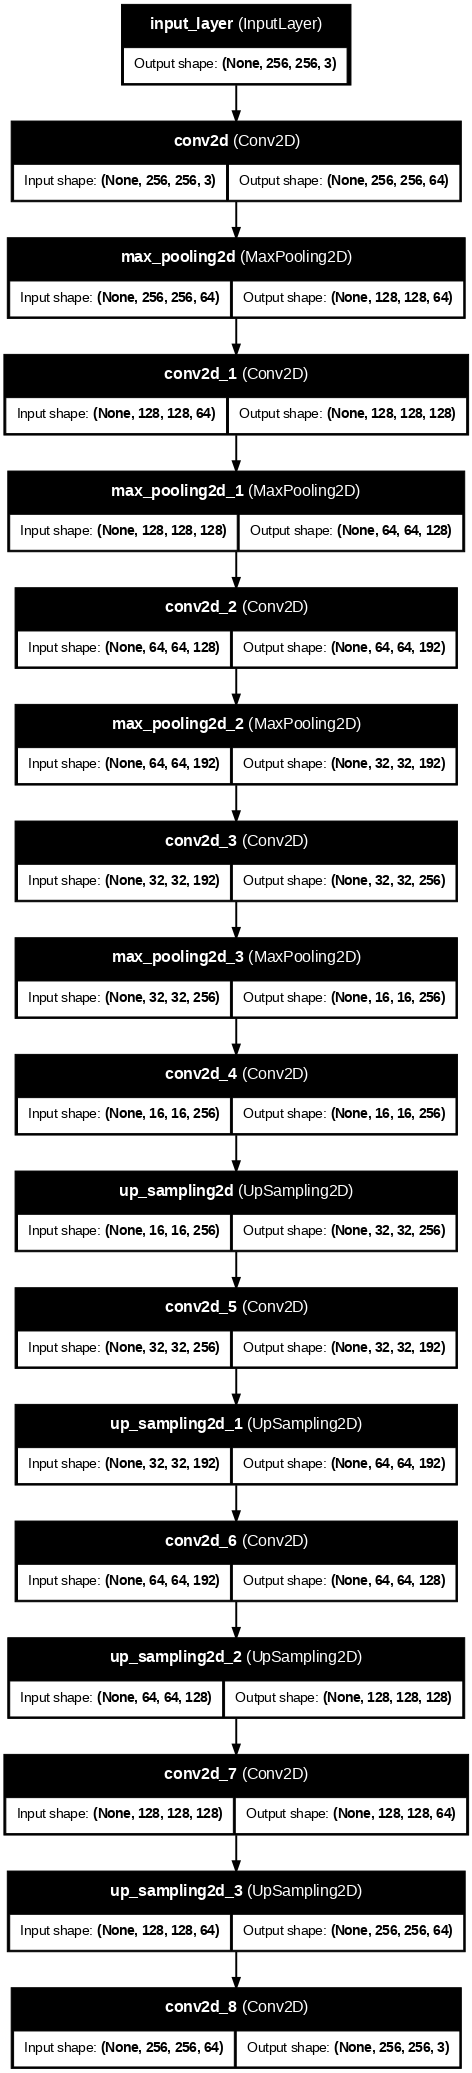

In [ ]:
# создание компиляция и вывод информации по cnn архитектуре
cnn_autoencoder = create_cnn_autoencoder_model(input_shape=(*img_size, 3), num_layers=4)
cnn_autoencoder.compile(optimizer=cnn_autoencoder_optimizer, loss='mse')
cnn_autoencoder.summary() # отчет о структуре модели
# график структуры модели
tf.keras.utils.plot_model(cnn_autoencoder, f"cnn_autoencoder_{size}.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d_11[0][0],  │
│                     │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    147,584 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_14[0][0],  │
│                     │ 128)              │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    221,376 │ activation_1[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    331,968 │ max_pooling2d_6[… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │    331,968 │ conv2d_16[0][0] 

 Total params: 6,495,363 (24.78 MB)

 Trainable params: 6,495,363 (24.78 MB)

 Non-trainable params: 0 (0.00 B)

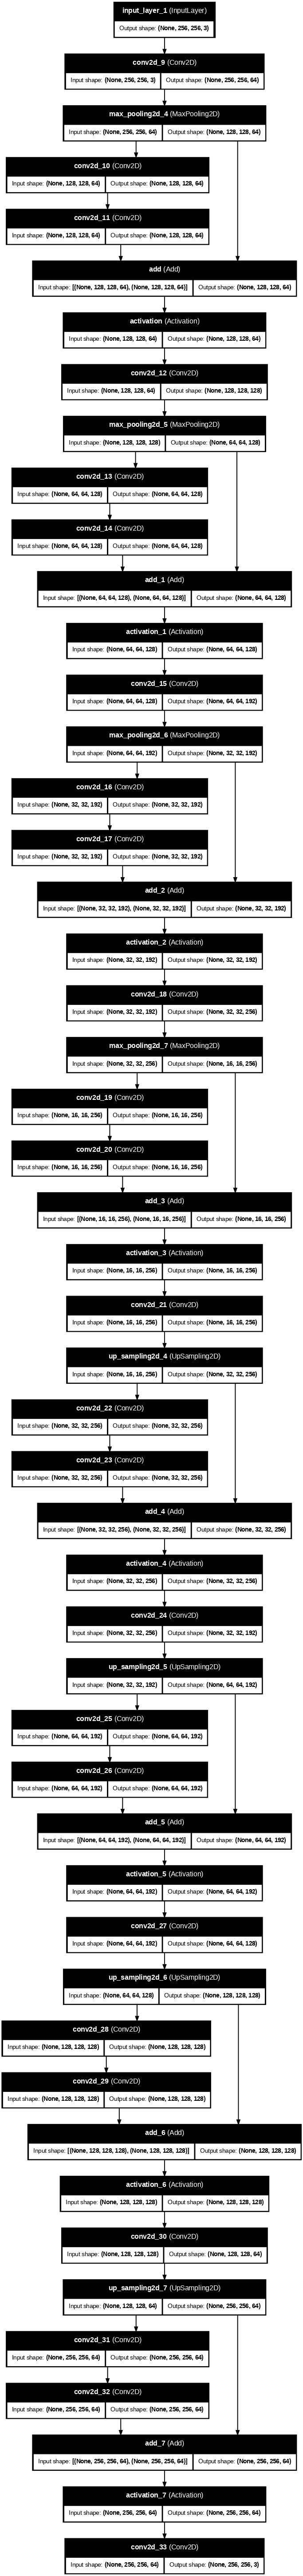

In [ ]:
# создание компиляция и вывод информации по residual архитектуре
residual_autoencoder = create_residual_block_model(input_shape=(*img_size, 3), num_layers=4)
residual_autoencoder.compile(optimizer=residual_autoencoder_optimizer, loss='mse')
residual_autoencoder.summary() # отчет о структуре модели
# график структуры модели
tf.keras.utils.plot_model(residual_autoencoder, f"residual_autoencoder_{size}.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)


## 6. ОБУЧЕНИЕ

**Загрузить веса для продолжения обучения**

In [ ]:
try:
    cnn_autoencoder.load_weights(cnn_autoencoder_checkpoint.format(epoch=last_epoch))
except FileNotFoundError as ex:
    print(ex)

try:
    residual_autoencoder.load_weights(residual_autoencoder_checkpoint.format(epoch=last_epoch))
except FileNotFoundError as ex:
    print(ex)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Обучим cnn модель**

In [ ]:
cnn_autoencoder_history = cnn_autoencoder.fit(train_gen,
                    epochs=epochs,
                    callbacks=cnn_autoencoder_callbacks,
                    validation_data=test_gen)

Epoch 1/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0053
Epoch 1: saving model to drive/MyDrive/checkpoints/cnn_autoencoder_256/train_1.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 137s 211ms/step - loss: 0.0053 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 2/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0043
Epoch 2: saving model to drive/MyDrive/checkpoints/cnn_autoencoder_256/train_2.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 137s 211ms/step - loss: 0.0043 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 3/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0040
Epoch 3: saving model to drive/MyDrive/checkpoints/cnn_autoencoder_256/train_3.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 139s 215ms/step - loss: 0.0040 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 4/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0036
Epoch 4: saving model to drive/MyDrive/checkpoints/cnn_autoencoder_256/train_4.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 137s 211ms/step - loss: 0.0036

In [ ]:
cnn_history = f'cnn_autoencoder_history_{size}'

In [ ]:
# сохраняем или обновляем историю
cnn_autoencoder_history = update_history(cnn_autoencoder_history.history, cnn_history)
!cp -r cnn_autoencoder_history_256.npy drive/MyDrive/

In [ ]:
# загружаем сохранённую истории
!cp -r drive/MyDrive/cnn_autoencoder_history_256.npy .
cnn_autoencoder_history = load_history(cnn_history)

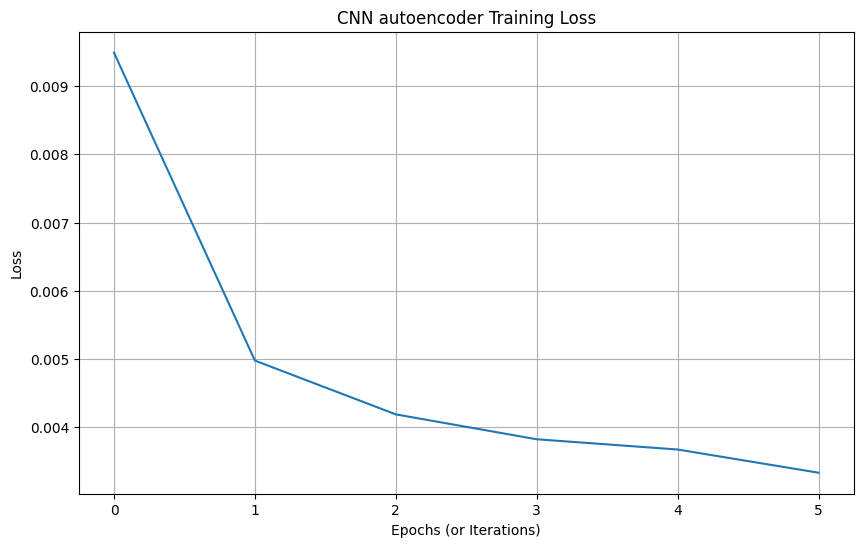

In [ ]:
# выводим на график
show_loss(cnn_autoencoder_history, title='CNN autoencoder Training Loss')

**Обучим residual модель**

In [ ]:
residual_autoencoder_history = residual_autoencoder.fit(train_gen,
                         epochs=epochs,
                         callbacks=residual_autoencoder_callbacks,
                         validation_data=test_gen)

Epoch 1/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0081
Epoch 1: saving model to drive/MyDrive/checkpoints/residual_autoencoder_256/train_1.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 165s 254ms/step - loss: 0.0081 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 2/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0079
Epoch 2: saving model to drive/MyDrive/checkpoints/residual_autoencoder_256/train_2.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 166s 256ms/step - loss: 0.0079 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 3/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0062
Epoch 3: saving model to drive/MyDrive/checkpoints/residual_autoencoder_256/train_3.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 170s 261ms/step - loss: 0.0062 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0039
Epoch 4: saving model to drive/MyDrive/checkpoints/residual_autoencoder_256/train_4.weights.h5
650/650 ━━━━━━━━━━━━━━━━━━━━ 167s 256ms

In [ ]:
residual_history = f'residual_autoencoder_history_{size}'

In [ ]:
# сохраняем или обновляем историю и выводим на график
residual_autoencoder_history = update_history(residual_autoencoder_history.history, residual_history)
!cp -r residual_autoencoder_history_256.npy drive/MyDrive/

In [ ]:
# загружаем сохранённую истории
!cp -r drive/MyDrive/residual_autoencoder_history_256.npy .
residual_autoencoder_history = load_history(residual_history)

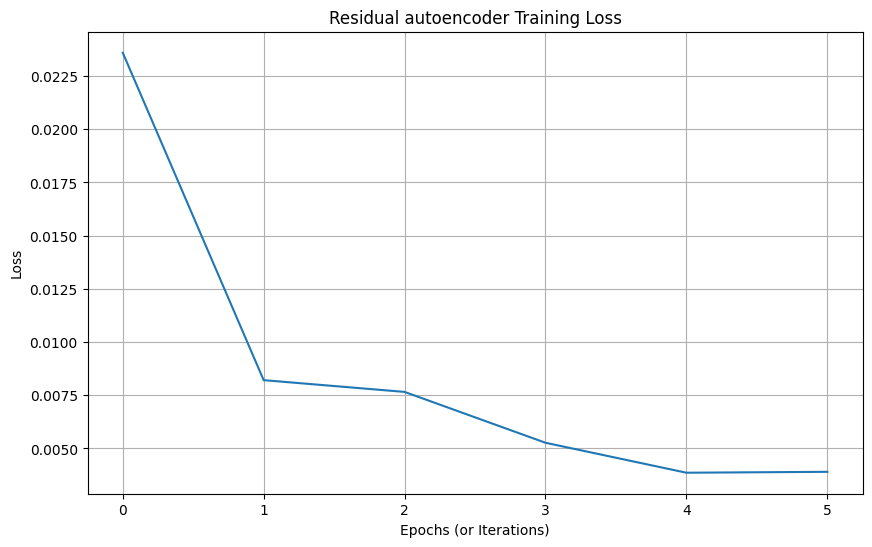

In [ ]:
# выводим график
show_loss(residual_autoencoder_history, title='Residual autoencoder Training Loss')

## 7 ОЦЕНКА РЕЗУЛЬТАТОВ

**СРАВНЕНИЕ РЕЗУЛЬТАТОВ**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


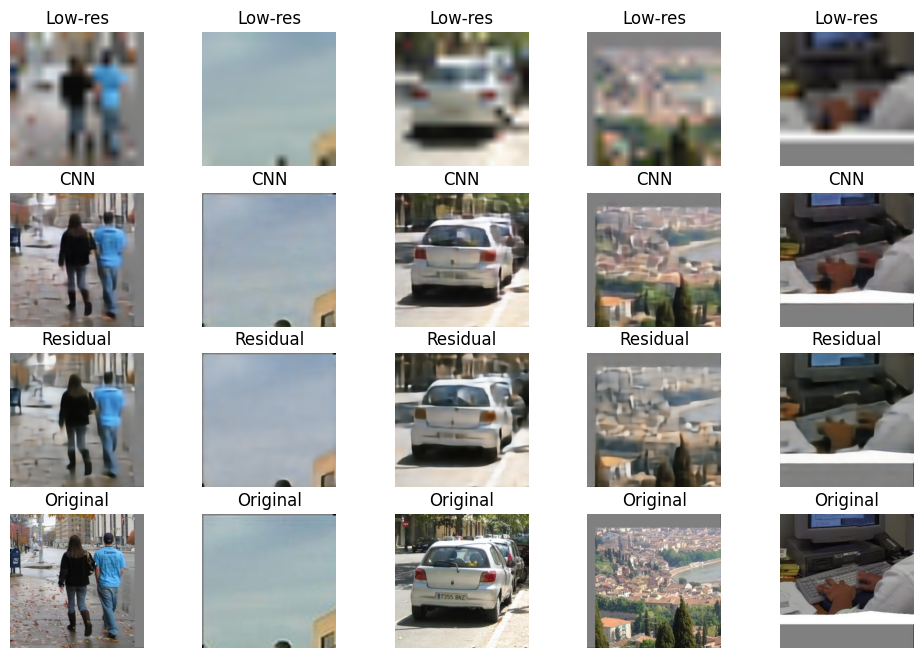

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
                  Model       MSE       PSNR
0       CNN Autoencoder  0.021335  16.709110
1  Residual Autoencoder  0.018819  17.254135


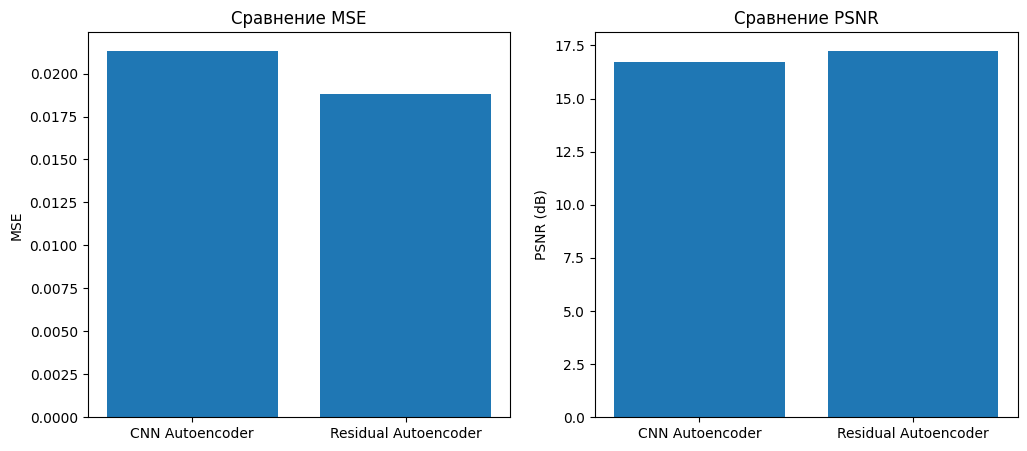

In [ ]:
cnn_reconstructed = cnn_autoencoder.predict(noise_res_test[:5])
res_reconstructed = residual_autoencoder.predict(noise_res_test[:5])

n = 5
plt.figure(figsize=(12, 8))
for i in range(n):
    # Низкое разрешение
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(low_res_test[i])
    plt.title("Low-res")
    plt.axis("off")

    # CNN Autoencoder
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(cnn_reconstructed[i])
    plt.title("CNN")
    plt.axis("off")

    # Residual Autoencoder
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(res_reconstructed[i])
    plt.title("Residual")
    plt.axis("off")

    # Оригинал
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")
plt.show()


cnn_preds = cnn_autoencoder.predict(low_res_test[:200])
res_preds = residual_autoencoder.predict(low_res_test[:200])

cnn_mse = mse(x_test[:200], cnn_preds)
res_mse = mse(x_test[:200], res_preds)

cnn_psnr = psnr(x_test[:200], cnn_preds)
res_psnr = psnr(x_test[:200], res_preds)

# =========================
# ТАБЛИЦА СРАВНЕНИЯ
# =========================
results = pd.DataFrame({
    "Model": ["CNN Autoencoder", "Residual Autoencoder"],
    "MSE": [cnn_mse, res_mse],
    "PSNR": [cnn_psnr, res_psnr]
})

print(results)

# =========================
# ВИЗУАЛИЗАЦИЯ МЕТРИК
# =========================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MSE
axes[0].bar(results["Model"], results["MSE"])
axes[0].set_title("Сравнение MSE")
axes[0].set_ylabel("MSE")

# PSNR
axes[1].bar(results["Model"], results["PSNR"])
axes[1].set_title("Сравнение PSNR")
axes[1].set_ylabel("PSNR (dB)")

plt.show()

**АНАЛИЗ РЕЗУЛЬТАТОВ**

Оба автокодировщика улучшают качество изображений.
- Residual Autoencoder демонстрирует более высокую детализацию и лучшее значение PSNR.
- CNN-автокодировщик проще и быстрее обучается, но качество ниже.
- Сравнительная таблица и графики подтверждают превосходство Residual Autoencoder по метрикам MSE и PSNR.

## 8. ВЫВОДЫ

- Разные архитектуры автокодировщиков по-разному влияют на качество восстановления.
- Residual Autoencoder показывает преимущество в качестве при увеличении разрешения.
- CNN-автокодировщик лучше подходит для быстрой прототипизации.
- Дальнейшее развитие: исследование VAE и GAN-подходов.